# Import and Drive mount

Note that if you want to run our notebook, you will first need to send us your email so that we can add you on our shared drive containing the data for our project. Furthermore, when running the cell starting with !pip install, if you have an earlier version of pandas, you will need to restart the kernel before running the cells and ckeck that the pandas version is at least `1.3.4`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas==1.3.4
import pandas as pd
print()
pd.__version__

'1.3.4'

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import bz2
import json
import os
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import pyarrow.parquet as pq
from datetime import datetime 
import seaborn as sns

# Utility function and paths variables

In [ ]:
def apply_to_stream(f, input_file, args=None, chunksize=1_000_000):
  """
    apply func to input_file and save in output_file

    Parameters:
      func :        fonction to apply of type : args = func(df_chunk, args)
      input_file :  input file
      args :        arguments of func 
      chunksize :   chunk size

    Returns:
      args :        arguments at the end of the execution
  """
  with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
    for chunk in tqdm(df_reader):
      args = f(chunk, args)
  return args

def write_df_chunk_to_file(df_chunk, file):
  """
    write the chunk in to the file

    Parameters:
      df_chunk :  fonction to apply of type : new_df_chunk, args = func(df_chunk, args)
      file :      file_stream
  """
  file.write(df_chunk.to_json(orient='records', lines=True).encode('utf-8'))

def apply_to_stream_and_save(func, input_file, output_file, args=None, chunksize=1_000_000, override=False):
  """
    apply func to input_file and save in output_file

    Parameters:
      func :        fonction to apply of type : new_df_chunk, args = func(df_chunk, args)
      input_file :  input file
      output_file : output file
      args :        arguments of func 
      chunksize :   chunk size
      override :    override output_file if alredy exist

    Returns:
      args :        arguments at the end of the execution
  """
  if(override or (isfile(input_file) and not isfile(output_file))):
    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
        with bz2.open(output_file, 'wb') as out_file:
            for df_chunk in tqdm(df_reader):
              new_df_chunk, args = func(df_chunk, args)
              write_df_chunk_to_file(new_df_chunk, out_file)
  return args


def apply_to_all_stream_and_save(func, all_input_file, output_file, args=None, chunksize=1_000_000, override=False):
  """
    apply func to all input_file and save in output_file

    Parameters:
      func :            fonction to apply of type : new_df_chunk, args = func(df_chunk, args)
      all_input_file :  input file
      output_file :     output file
      args :            arguments of func 
      chunksize :       chunk size
      override :        override output_file if alredy exist

    Returns:
      args :        arguments at the end of the execution
  """
  if(override or not isfile(output_file)):
    # Open only once the output file, so just append all the content to it
    with bz2.open(output_file, 'wb') as out_file:
      for key in all_input_file:
        input_file = all_input_file[key]
        print(f'==> File "{input_file}" start')
        with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
          for df_chunk in tqdm(df_reader):
            new_df_chunk, args = func(df_chunk, args)
            write_df_chunk_to_file(new_df_chunk, out_file)
                        
        print(f'==> File "{input_file}" processed')
  return args

def filter_file_and_save(func, input_file, output_file, name='', chunksize=1_000_000, override=False):
  """
    filter input_file and save in output_file

    Parameters:
      func :        fonction to apply of type : new_df_chunk = func(df_chunk)
      input_file :  input file
      output_file : output file
      chunksize :   chunk size
      override :    override output_file if alredy exist
  """
  if(override or (isfile(input_file) and not isfile(output_file))):
    def f(df, total_nb_rows):
      new_df = func(df)
      return new_df, (total_nb_rows + df.shape[0] - new_df.shape[0])
    total_nb_rows = apply_to_stream_and_save(f, input_file, output_file, 0, chunksize)
    print(f'Number of rows dropped {name} : {total_nb_rows}')

def count_nb_rows_in_file(input_file):
  """
    count nb rows in input_file

    Parameters:
      input_file :  input file
  """
  count = 0
  with pd.read_json(input_file, lines=True, compression='bz2', chunksize=750_000) as df_reader:
      for chunk in df_reader:
          count += chunk.shape[0]

  print(f'Total number of records in {input_file}: {count}')

In [ ]:
drive = '/content/drive/Shareddrives/ada-teamphilippe/'

# Source Data
wikidata_folder = drive + 'Wikidata/'
quotebank_folder = drive + 'Quotebank/'

wikidata_speaker = wikidata_folder + 'speaker_attributes.parquet/'
wikidata_labels = wikidata_folder + 'wikidata_labels_descriptions.csv.bz2'
wikidata_labels_quotebank = wikidata_folder + 'wikidata_labels_descriptions_quotebank.csv.bz2'
wikidata_speaker_parquet = [join(wikidata_speaker, f) for f in listdir(wikidata_speaker) if (isfile(join(wikidata_speaker, f) )and f.endswith('.parquet'))]

# Prosesed Data
data_out_folder = drive + 'data/'

cleaned_quotes_folder = data_out_folder + 'cleaned_quotes/'
speaker_quotes_folder = data_out_folder + 'speaker_quotes/'
sampled_quotes_folder = data_out_folder + 'sampled_quotes/'
sampled_speaker_quotes_folder = data_out_folder + 'sampled_speaker_quotes/'

# Files
quotes_name = {}
quotes = {}

cleaned_quotes = {}
speaker_quotes = {}
sampled_quotes = {}
sampled_speaker_quotes = {}

for year in range(2015, 2020 + 1):
  quotes_name[year] = f'quotes-{year}.json.bz2'
  quotes[year] = quotebank_folder + quotes_name[year]

  cleaned_quotes[year] = cleaned_quotes_folder + quotes_name[year]
  speaker_quotes[year] = speaker_quotes_folder + quotes_name[year]
  sampled_quotes[year] = sampled_quotes_folder + quotes_name[year]
  sampled_speaker_quotes[year] = sampled_speaker_quotes_folder + quotes_name[year]

sampled_quotes_all = data_out_folder + 'sampled_quotes_all.json.bz2'
sampled_speaker_quotes_all = data_out_folder + 'sampled_speaker_quotes_all.json.bz2'

# Quotebank dataset formats, cleaning, compliting and sampling

## Formats of the differents features

In [ ]:
def get(quotes, nb):
  """
    get first chunk of quotes of size nb

    Parameters:
      quotes :  quotes file name
      nb :      number of rows

    Returns:
      chunk :   chunk of the file
  """
  with pd.read_json(quotes, lines=True, compression='bz2', chunksize=nb) as df_reader:
    for chunk in df_reader:
      return chunk

In [ ]:
first_chunk = get(quotes[2015], 50)

In [ ]:
first_chunk.head(50)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E
1,2015-12-08-029916,How FFA scored 32 own goals in 18 months and C...,None,[],2015-12-08 00:00:00,2,"[[None, 0.563], [David Gallop, 0.437]]",[http://feeds.theroar.com.au/~r/theroar/~3/tZ3...,E
2,2015-09-10-000206,[ Amy ] was placed under an unacceptable amoun...,None,[],2015-09-10 21:18:59,1,"[[None, 0.9634], [Amy Robinson, 0.0366]]",[http://www.thefashionspot.com/buzz-news/lates...,E
3,2015-07-23-032707,How High Will These Numbers Go?,None,[],2015-07-23 14:57:49,3,"[[None, 0.9019], [Chubby Checker, 0.0981]]","[http://www.billboard.com/node/6641719, http:/...",E
4,2015-10-04-000115,[ Ban ] recalls that hospitals and medical per...,Ban Ki-moon,[Q1253],2015-10-04 08:27:38,2,"[[Ban Ki-moon, 0.8399], [None, 0.1601]]",[http://muslimnews.co.uk/news/middle-east/afgh...,E
5,2015-06-19-016191,How Indian values and karma can help business ...,Sri Sri Ravi Shankar,[Q468374],2015-06-19 15:32:16,1,"[[Sri Sri Ravi Shankar, 0.4169], [None, 0.2844...",[http://newkerala.com/news/2015/fullnews-74877...,E
6,2015-08-31-000309,[ But ] We were able to network within our com...,Jamal Rifi,[Q19874690],2015-08-31 22:59:36,1,"[[Jamal Rifi, 0.6109], [None, 0.3891]]",[http://sbs.com.au/content/muslim-leader-named...,E
7,2015-09-21-030618,How it worked is that they had a keyboard and ...,Richard Burmeister,[Q18601741],2015-09-21 19:00:00,1,"[[Richard Burmeister, 0.875], [None, 0.125]]",[http://sarahrosedevilliers.wordpress.com/2015...,E
8,2015-12-10-000332,[ C ] harter operators working through third-p...,Diane Ravitch,[Q5271548],2015-12-10 17:51:45,1,"[[Diane Ravitch, 0.8078], [None, 0.1922]]",[http://enewspf.com/2015/12/10/report-shows-ho...,E
9,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E


In [ ]:
first_chunk.iloc[1]['speaker'] == 'None'

True

We will replace these string 'None' by proper Nan to ease the processing with pandas.

In [ ]:
first_chunk['quoteID'].describe()

count                    50
unique                   50
top       2015-08-31-000271
freq                      1
Name: quoteID, dtype: object

In [ ]:
first_chunk['quotation'].describe()

count                                                    50
unique                                                   50
top       ... a great day for veterans here in Littleton...
freq                                                      1
Name: quotation, dtype: object

In [ ]:
first_chunk['speaker'].describe()

count       50
unique      38
top       None
freq        13
Name: speaker, dtype: object

In [ ]:
first_chunk['qids'].describe()

count     50
unique    38
top       []
freq      13
Name: qids, dtype: object

In [ ]:
first_chunk['date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                      50
unique                     50
top       2015-08-31 02:10:00
freq                        1
first     2015-03-08 06:11:56
last      2015-12-31 17:05:06
Name: date, dtype: object

We will need to transform the date column type to a proper datetime type.

In [ ]:
first_chunk['numOccurrences'].describe()

count    50.000000
mean      2.200000
std       4.961073
min       1.000000
25%       1.000000
50%       1.000000
75%       1.750000
max      35.000000
Name: numOccurrences, dtype: float64

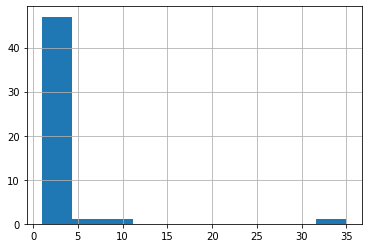

In [ ]:
first_chunk['numOccurrences'].hist()
plt.show()

In [ ]:
first_chunk['probas'].describe()

count                                                    50
unique                                                   50
top       [[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...
freq                                                      1
Name: probas, dtype: object

The probas feature already contains python list.

In [ ]:
first_chunk['urls'].describe()

count                                                    50
unique                                                   50
top       [http://www.unionleader.com/article/20150831/N...
freq                                                      1
Name: urls, dtype: object

In [ ]:
first_chunk['phase'].describe()

count     50
unique     1
top        E
freq      50
Name: phase, dtype: object

It seems that the column 'phase' does contain much information since it is always the same value (to be confirmed on the entire dataset). If it is the case, we can just drop it.

In [ ]:
for year in range(2015, 2020 + 1):
  count_nb_rows_in_file(quotes[year])

## Cleaning
As our project idea is based not only on the quote but also on the author, we decided to drop the rows that were having None as speaker or the rows where the speaker has a probability less than 0.5.

In [ ]:
def cast_date_remove_authors_low_proba(df_chunk, nb_rows_dropped):
  """
    cast the date and remove authors with low probability

    Parameters:
      df_chunk :        chunk of the data frame 
      nb_rows_dropped : number of rows dropped

    Returns:
      df_chunk :        chunk of the data frame updated
      nb_rows_dropped : number of rows dropped updated
  """
  def create_col_author_highest_proba(row):
    max_proba = -1.0
    max_author = None
    
    for author, proba in row['probas']:
      if float(proba) > max_proba:
        max_proba = float(proba)
        max_author = author
            
    return max_author, max_proba
      
      
  # Cast the date column to datetime
  df_chunk['date'] = pd.to_datetime(df_chunk['date'])
  
  # Cast the string 'None' for the speaker column to proper np.nan
  df_chunk['speaker'] = df_chunk['speaker'].replace('None', np.nan)
  
  # Drop all the rows where the author is nan
  df_chunk.dropna(subset=['speaker'], inplace=True)
  
  tmp = pd.DataFrame()
  # Create 2 new columns with author, proba that has the highest proba
  tmp[['author_highest_proba', 'highest_proba']] = df_chunk.apply(create_col_author_highest_proba, axis=1, result_type='expand')
  
  # Check if for some rows the author is not the author with the highest proba
  if not df_chunk['speaker'].equals(tmp['author_highest_proba']):
    print('========================================================================')
    print('The column "speaker" is not equal to the column "author_highest_proba" !')
    print('========================================================================')
    
    # Print where the 2 columns are different
    print(df_chunk[np.argwhere(not df_chunk['speaker'].equals(tmp['author_highest_proba']))])
      
  # Drop the rows where the highest proba is < 0.5
  mask = tmp['highest_proba'] < 0.5
  nb_rows_dropped += mask.sum()
  df_chunk = df_chunk[~mask]
  
  return df_chunk, nb_rows_dropped

Number of rows dropped in quotes 2015 : 662490<br>
Number of rows dropped in quotes 2016 : 453279<br>
Number of rows dropped in quotes 2017 : 859026<br>
Number of rows dropped in quotes 2018 : 883951<br>
Number of rows dropped in quotes 2019 : 695779<br>
Number of rows dropped in quotes 2020 : 160320<br>

Total number of records in file "cleaned-quotes-2015" : 13195548<br>
Total number of records in file "cleaned-quotes-2016" : 8653435<br>
Total number of records in file "cleaned-quotes-2017" : 16474272<br>
Total number of records in file "cleaned-quotes-2018" : 16786468<br>
Total number of records in file "cleaned-quotes-2019" : 13487515<br>
Total number of records in file "cleaned-quotes-2020" : 3283285<br>

In [ ]:
for year in range(2015, 2020 + 1):
  filter_file_and_save(cast_date_remove_authors_low_proba, quotes_name[year], quotes[year], cleaned_quotes[year])

## Sampling the dataset
Since the original dataset is very large, it is quite cumbersome to do our first analyses on it because it takes a lot of time. Therefore to get a first glance at the data, test our functions, etc, we sample the original dataset to obtain a much smaller one.


Now arises the question on how should we sample it ? Should we just sample uniformly at random a fixed number of quotes per year ? Should we look for biases in the data as seen in the "Observation studies" lecture and sample the dataset accordingly ? For example, we could look at the proportion of women/men authors in each year and decide to balance the samples according to this. However, this would require to merge the dataset with the Wikidata parquet file and so on. So for now, we decided to start by sampling uniformly at random 500'000 quotes from each year from the cleaned dataset we created above. Since the sampling is random, this should conserve the biases of the origininal dataset and therefore we will be able to detect them faster (in terms of computational time). Obviously, we will run our analyses on the full dataset once in the end to get more representative results.

In [ ]:
def sample_dataset(input_file, output_file, nb_samples, seed=1, chunksize=750_000):
  if(isfile(input_file) and not isfile(output_file)):
    # First need to get back the quoteID of all the rows in the file
    quoteIDs = []
    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
      for df_chunk in tqdm(df_reader):
        quoteIDs += df_chunk['quoteID'].tolist()

    print('==> quoteIDs processed')

    # Choose nb_samples uniformly at random
    rng = np.random.default_rng(seed=seed)
    quoteIDs_samples = rng.choice(quoteIDs, nb_samples, replace=False)

    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
      with bz2.open(output_file, 'wb') as out_file:
        for df_chunk in tqdm(df_reader):
          # Keep only chosen rows
          df_result = df_chunk.loc[df_chunk['quoteID'].isin(quoteIDs_samples), :]
          
          # Write result chunk to file
          write_df_chunk_to_file(df_result, out_file)

    print(f'==> Succesfully sampled {nb_samples} out of {len(quoteIDs)} from file "{input_file}"')

In [ ]:
nb_samples = 300_000
for year in range(2015, 2020 + 1):
  print(f'==> {year} start')
  sample_dataset(cleaned_quotes[year], sampled_quotes[year], nb_samples)
  print(f'==> {year} processed')

To ease the processing on the sampled dataset, we will merge the 6 sampled files into a single one.

In [ ]:
# Now let's merge these 6 sampled files
apply_to_all_stream_and_save(lambda df,args: (df,args),
                            sampled_quotes,
                            sampled_quotes_all)

## Add Wikidata information

As in our project we need the age, sex and nationality, we decided to add the information from wikidata related to this directly in the dataset.

In [ ]:
def get_labels_from_QID():
  """
    return a map from QID to labels

    Returns:
      labels_from_QID : a map from QID to labels
  """
  labels_from_QID = {}
  with pd.read_csv(wikidata_labels_quotebank, compression='bz2', chunksize=1_000_000) as df_reader:
    for chunk in df_reader:
      for index,row in chunk.iterrows():
        labels_from_QID[str(row["QID"])] = str(row["Label"])
  return labels_from_QID

def get_Label(QIDs, labels_from_QID):
  """
    get the label from QIDs

    Parameters:
      QIDs :            list of QIDs
      labels_from_QID : map from QID to labels

    Returns:
      labels :          list of labels
  """
  if(str(QIDs) == 'None'):
    return None
  return [labels_from_QID[str(x)] for x in QIDs if str(x) in labels_from_QID]

def first_if_not_None(element):
  """
    return the first element or None

    Parameters:
      element : list of elements or None

    Returns:
      labels :  the first element or None
  """
  if (str(x) == 'None'):
    return None
  return str(x[0])[1:-10]

def get_speaker_atribut():
  """
    return a map from QID to speaker atribut

    Returns:
      speaker_atribut : a map from QID to speaker atribut
  """
  labels_from_QID = get_labels_from_QID()
  speaker_atribut = {}

  for file in wikidata_speaker_parquet:
    df = pq.read_pandas(file)
    for i in range(len(df['aliases'])):

      result = {
        'date_of_birth' : first_if_not_None(df['date_of_birth'][i]),
        'gender' : get_Label(df['gender'][i], labels_from_QID),
        'nationality' : get_Label(df['nationality'][i], labels_from_QID)
      }
      if(result['date_of_birth'] != None or result['gender'] != None or result['nationality'] != None):
        speaker_atribut[str(df['id'][i])] = result

  return speaker_atribut

In [ ]:
def add_speaker_atribut(df_chunk, args):
  """
    add speaker atribut to the data frame 

    Parameters:
      df_chunk :          chunk of the data frame
      args :
        speaker_atribut:  map from QID to speaker atribut
        drops:            number of rows dropped

    Returns:
      new_df_chunk :      chunk of the data frame updated
      args :
        speaker_atribut:  map from QID to speaker atribut
        drops:            number of rows dropped updated
  """
  speaker_atribut, drops = args

  new_df_chunk = df_chunk[df_chunk['qids'].apply(lambda row : (str(row[0]) in speaker_atribut))]

  def compute_age(row):
    """
    compute the age of the speaker

    Parameters:
      row : row of the data frame

    Returns:
      age : age of the speaker
  """
    date_of_birth = speaker_atribut[str(row['qids'][0])]['date_of_birth']
    date = row['date']
    if(date == None or date_of_birth == None):
      return None

    
    date_of_birth = date_of_birth\
      .replace('-00', '-01')\
      .replace('-02-31', '-02-29')\
      .replace('-06-31', '-06-30')

    date = datetime.strptime(str(date),'%Y-%m-%d %H:%M:%S')
    try:
      date_of_birth = datetime.strptime(date_of_birth,'%Y-%m-%d')
      return (date - date_of_birth).days//365.25
    except ValueError:
      try:
        #arrive there if the 29 february is not a valid date for this year
        date_of_birth = date_of_birth\
          .replace('-02-29', '-02-28')
        date_of_birth = datetime.strptime(date_of_birth,'%Y-%m-%d')
        return (date - date_of_birth).days//365.25
      except ValueError:
        #unknown exception
        print()
        print('ValueError:')
        print('date_of_birth', date_of_birth)
        print()
        return None

  new_df_chunk['speaker_age'] = new_df_chunk.apply(lambda row : compute_age(row), axis=1)
  new_df_chunk['speaker_gender'] = new_df_chunk.apply(lambda row : speaker_atribut[str(row['qids'][0])]['gender'], axis=1)
  new_df_chunk['speaker_nationality'] = new_df_chunk.apply(lambda row : speaker_atribut[str(row['qids'][0])]['nationality'], axis=1)

  drops += len(df_chunk) - len(new_df_chunk)
  return new_df_chunk, (speaker_atribut, drops)
speaker_atribut = {}

Number of rows dropped in quotes 2015 : 183692<br>
Number of rows dropped in quotes 2016 : 125189<br>
Number of rows dropped in quotes 2017 : 251961<br>
Number of rows dropped in quotes 2018 : 265048<br>
Number of rows dropped in quotes 2019 : 218068<br>
Number of rows dropped in quotes 2020 : 56564<br>

Total number of records in file "speaker-quotes-2015" : 13011856<br>
Total number of records in file "speaker-quotes-2016" : 8528246<br>
Total number of records in file "speaker-quotes-2017" : 16222311<br>
Total number of records in file "speaker-quotes-2018" : 16521420<br>
Total number of records in file "speaker-quotes-2019" : 13269447<br>
Total number of records in file "speaker-quotes-2020" : 3226721<br>

In [ ]:
for year in range(2015, 2020 + 1):
  if(isfile(cleaned_quotes[year]) and not isfile(speaker_quotes[year])):
    if(len(speaker_atribut) == 0):
      speaker_atribut = get_speaker_atribut()
    print(f'==> {year} start')
    args = apply_to_stream_and_save(add_speaker_atribut, cleaned_quotes[year], speaker_quotes[year], args=(speaker_atribut, 0), chunksize=500_000)
    _, drops = args
    print(f'==> {year} processed, row deleted: {drops}')

In [ ]:
for year in range(2015, 2020 + 1):
  if(isfile(sampled_quotes[year]) and not isfile(sampled_speaker_quotes[year])):
    if(len(speaker_atribut) == 0):
      speaker_atribut = get_speaker_atribut()
    print(f'==> {year} start')
    args = apply_to_stream_and_save(add_speaker_atribut, sampled_quotes[year], sampled_speaker_quotes[year], args=(speaker_atribut, 0), chunksize=500_000)
    _, drops = args
    print(f'==> {year} processed, row deleted: {drops}')

In [ ]:
# Now let's merge these 6 sampled files
apply_to_all_stream_and_save(lambda df,args: (df,args),
                            sampled_speaker_quotes,
                            sampled_speaker_quotes_all)

# Data exploration

In this part, we choose to plot relevant distributions for our project. Since our project involves a temporal component, we choose to plot and explore the data year by year on our sampled dataset. 

Some remarks: 
- For the histogram of the number of quotes per age, we limit ourselves to people whose ages are below 120.
- To plot a meaningful representation of the number of quotes per country, we keep only the quotes whose author has only one nationality. 

Our initial objective was to give a year by year analysis but since the plots are really close between the year, we think that it is more pertinent to give a global explanation rather than repeating ourselves. Nevertheless, we will point out some of the differences. 

In [ ]:
plt_aspect=2
plt.figure(figsize=(12,9))

def describe(df, year):
  """
    describe the distribution of the data frame

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  print(year, ':')
  print(df.describe())

def num_occurences(df, year):
  """
    plot the distribution of the number of occurences per quotes

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  ax = sns.displot(data=df, x='numOccurrences', log_scale=(True, True), aspect=plt_aspect)
  plt.suptitle(f'Histogram of number of quotes per number of occurences ({year})')
  ax.set(xlabel="Number of occurences",ylabel="Number of quotes")
  plt.show()

def quotes_by_author(df, year):
  """
    plot the distribution of the number of quotes by author

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  # Count the number of quote per author
  df['Author'] = df.apply(lambda row : row['qids'][0], axis=1)
  var = df.groupby('Author').agg(count=pd.NamedAgg(column="Author", aggfunc="count"))
  # Display the distribution
  ax =sns.displot(data=var, x='count', log_scale=(True, True), aspect=plt_aspect)
  ax.set(xlabel="Quotes per author",ylabel="Number of author")
  plt.suptitle(f'Histogram of number of quotes by Author ({year})')
  plt.show()

def quotes_per_ages(df, year):
  """
    plot a histogram of the number of quotes by ages

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  df = df[df['speaker_age'] < 120]
  # Create a histogram of the number of quotes per age
  ax = sns.displot(data=df[pd.notna(df['speaker_age'])], x='speaker_age', log_scale=(False, True), bins=120, aspect=plt_aspect)
  ax.set(xlabel="Ages",ylabel="Count per ages")
  plt.suptitle(f'Number of quotes per ages ({year})')
  plt.show()

def to_gender_string(gender):
  """
    return the gender in string

    Parameters:
      gender :        list of gender

    Returns:
      gender_string : gender in string
  """
  if gender == None :
    return "None"
  s = ""
  for v in set(gender) :
    s += ", " + v
  return s[2:]

def to_set(x):
  """
    return the set of the list

    Parameters:
      x :   list

    Returns:
      set : set
  """
  if x == None :
    return None
  return set(x)

def quotes_per_sex(df, year):
  """
    plot a distribution of the number of quotes per sex

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  # Create new columns containing the set of sex of the author
  df['speaker_gender_set'] = df['speaker_gender'].apply(to_gender_string)
  ax = sns.displot(data = df, x = 'speaker_gender_set' , log_scale = (False,True), aspect=plt_aspect)
  plt.xticks(rotation=90)
  ax.set(ylabel="Quotes per sex")
  plt.suptitle(f'Bar plot of number of quotes by gender  ({year})')
  plt.show()

def quotes_per_nationality(df, year):
  """
    plot a distribution of the number of quotes per nationality

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  # Display the total number of quotes and the number of quotes with an author that has only one nationality
  df['speaker_nationality_set'] = df['speaker_nationality'].apply(lambda x: to_set(x))
  print(f"Total number of quotes: {len(df)}")  
  print(f"Number of quotes with only one nationality: {df['speaker_nationality_set'].apply(lambda x: (x is not None) and (len(x)==1)).sum()}")

  # Counte the number of quotes per nationality where the author has only one nationality 
  one_nat = pd.DataFrame()
  one_nat['nationality_set'] = df['speaker_nationality_set'].apply(lambda x: list(x)[0] if ((x is not None) and (len(x)==1)) else np.nan).dropna()
  one_nat = one_nat.groupby('nationality_set').agg(count=pd.NamedAgg(column="nationality_set", aggfunc="count"))

  # Plot the number of quotes per nationality histogram
  ax = sns.displot(data = one_nat, x = 'count' , log_scale = (True, True), bins=50, aspect=plt_aspect)
  plt.xticks(rotation=90)
  ax.set(xlabel="Number of quotes", ylabel="Number of nationality")
  plt.suptitle(f'Number of nationality by number of ({year})')
  plt.show()

def quotes_per_day(df, year):
  """
    plot a distribution of the number of quotes per day of year

    Parameters:
      df :    the data frame of a specific year
      year :  the year
  """
  # Compute the number of quotes per day of year 
  day_of_year = pd.DataFrame()
  day_of_year['day_of_year'] = df['date'].apply(lambda x: x.day_of_year)

  # Plot the line plot for the full year
  from matplotlib import rcParams
  rcParams['figure.figsize'] = 25,4
  ax = sns.histplot(data=day_of_year, x='day_of_year', binwidth=1)
  ax.set(xlabel="Day of year",ylabel="Count per day")
  plt.suptitle(f'Number of quotes per day ({year})')
  plt.show()

def describe_year(df, year):
  print(f"==== Exploration sampled quotes for year {year} ====")
  # Statistical description of this year data.
  print("\n\nStatistical summary\n\n")
  print(df.describe())
  # Display all the plot for the current year
  print("\n\nVisualisations\n\n")
  numOccurences(df, year)
  quotesByAuthor(df, year)
  quotesPerAges(df[df['speaker_age'] < 120], year)
  quotesPerSex(df, year)
  quotesPerNationality(df, year)
  quotes_per_day(df, year)
  
def plot_all_years(func, df_zip):
  for df, year in df_zip:
    func(df, year)
    print()


In [ ]:
df_zip = [(pd.read_json(sampled_speaker_quotes[year], lines=True, compression='bz2'), year) for year in range(2015, 2020 + 1)]

In [ ]:
plot_all_years(describe, df_zip)

In [ ]:
plot_all_years(num_occurences, df_zip)

The first good insight we have is that both the number of occurences per quote and the number of quotes seems to follow a power low as they PDF as the histograms looks like a line in a log-log plot. We can also see that there are some extreme outliers in each of the plot.

In [ ]:
plot_all_years(quotes_by_author, df_zip)

Same as before, we can see that the number of quotes per author seems to follow a power law.


In [ ]:
plot_all_years(quotes_per_ages, df_zip)

As explained earlier, to plot the histogram, we kept only the quoter with an age that between 0 and 120 since our project will mainly focus on person that are still alive (as we want to study the evolution). Keeping the age of people which are more than 120 years old will not give us any information. In the range 0 to 120 years old, we can see that the distribution is almost symmetrical with most of the data point concentrated between 20 and 100 years. The mode of the distribution is around 50 years. 

In [ ]:
plot_all_years(quotes_per_sex, df_zip)

When we look at the plot representing the number of quotes per sex, we can see that most of the quotes are from men or women. We were really suprised to see how many different genders they are in our data but we can also see that they represent a minority.

In [ ]:
plot_all_years(quotes_per_nationality, df_zip)

As we will probably try to group author by nationality in our project, we plotted the number of quotes per nationality in each year. We can see that there is a kind of trend where : 
- There is a lot of nationality with only one quote.
- Between 10 and 1000 quotes per nationality, the distribution is close to uniform. 
- Some nationalities between 1000 and 10'000 quotes  
- One extreme nationality with around 100'000 quotes. 

In [ ]:
plot_all_years(quotes_per_day, df_zip)







Finally, we plotted the number of quotes per day over the years. As we can see in the plot below, we can see a pattern where the number of quotes in the day of the week is higher than during the week-end. We can also note some interesting things: 
- The dates of the quotes stopped around the 110th day of 2020 which makes perfectly sense as Quotebank was created using data until April 2020. 
- A more interesting thing to note is that we can see that in 2015, in 2016 as well as the start of 2017, we have a really low number of quotes. Since we are working on a sample of the original dataset to perform this exploratory data analysis, we first thought that there might be a problem with our sampling method. However, since we sample quotes at random from the original dataset, it is very unlikely that we will get such a small number of quotes in these periods and a large number in the other. Furthermore, we can see that this doesn't happen in the later years (from February 2017 to 2020) where we can only see this weekly cycle.

